# The MPC out of Credit vs the MPC Out of Income

[![badge](https://img.shields.io/badge/Launch%20using%20-Econ--ARK-blue)](https://econ-ark.org/materials/mpc-out-of-credit-vs-mpc-out-of-income#launch)

This notebook compares the Marginal Propensity to Consume (MPC) out of an increase in a credit limit, and the MPC out of transitory shock to income.

The notebook is heavily commented to help newcomers, and does some things (like importing modules in the body of the code rather than at the top), that are typically deprecated by Python programmers.  This is all to make the code easier to read and understand.

The notebook illustrates one simple way to use HARK: import and solve a model for different parameter values, to see how parameters affect the solution.

The first step is to create the ConsumerType we want to solve the model for.

In [1]:
# Import the HARK ConsumerType we want
# Here, we bring in an agent making a consumption/savings decision every period, subject
# to transitory and permanent income shocks.
import matplotlib.pyplot as plt  # We need this module to change the y-axis on the graphs
from HARK.utilities import plot_funcs
from copy import deepcopy
from HARK.ConsumptionSaving.ConsIndShockModel import KinkedRconsumerType
from HARK.ConsumptionSaving.ConsIndShockModel import IndShockConsumerType

In [2]:
# Now, create an instance of the consumer type using the default parameter values
# We create the instance of the consumer type by calling IndShockConsumerType()
# We use the default parameter values by passing **Params.init_idiosyncratic_shocks as an argument
BaselineExample = IndShockConsumerType()

In [3]:
# Note: we've created an instance of a very standard consumer type, and many assumptions go
# into making this kind of consumer.  As with any structural model, these assumptions matter.
# For example, this consumer pays the same interest rate on
# debt as she earns on savings.  If instead we wanted to solve the problem of a consumer
# who pays a higher interest rate on debt than she earns on savings, this would be really easy,
# since this is a model that is also solved in HARK.  All we would have to do is import that model
# and instantiate an instance of that ConsumerType instead.  As a homework assignment, we leave it
# to you to uncomment the two lines of code below, and see how the results change!


BaselineExample = KinkedRconsumerType()

The next step is to change the values of parameters as we want.

To see all the parameters used in the model, along with their default values, see $\texttt{ConsumerParameters.py}$

Parameter values are stored as attributes of the $\texttt{ConsumerType}$ the values are used for. For example, the risk-free interest rate $\texttt{Rfree}$ is stored as $\texttt{BaselineExample.Rfree}$. Because we created $\texttt{BaselineExample}$ using the default parameters values at the moment $\texttt{BaselineExample.Rfree}$ is set to the default value of $\texttt{Rfree}$ (which, at the time this demo was written, was 1.03).  Therefore, to change the risk-free interest rate used in $\texttt{BaselineExample}$ to (say) 1.02, all we need to do is:

In [4]:
# Change the Default Riskfree Interest Rate
BaselineExample.Rfree = 1.02

In [5]:
# Change some parameter values
BaselineExample.Rfree = 1.02  # change the risk-free interest rate
BaselineExample.CRRA = 2.0  # change  the coefficient of relative risk aversion
BaselineExample.BoroCnstArt = -0.3  # change the artificial borrowing constraint
BaselineExample.DiscFac = (
    0.5  # chosen so that target debt-to-permanent-income_ratio is about .1
)
# i.e. BaselineExample.solution[0].cFunc(.9) ROUGHLY = 1.

# There is one more parameter value we need to change.  This one is more complicated than the rest.
# We could solve the problem for a consumer with an infinite horizon of periods that (ex-ante)
# are all identical.  We could also solve the problem for a consumer with a fininite lifecycle,
# or for a consumer who faces an infinite horizon of periods that cycle (e.g., a ski instructor
# facing an infinite series of winters, with lots of income, and summers, with very little income.)
# The way to differentiate is through the "cycles" attribute, which indicates how often the
# sequence of periods needs to be solved.  The default value is 1, for a consumer with a finite
# lifecycle that is only experienced 1 time.  A consumer who lived that life twice in a row, and
# then died, would have cycles = 2.  But neither is what we want.  Here, we need to set cycles = 0,
# to tell HARK that we are solving the model for an infinite horizon consumer.


# Note that another complication with the cycles attribute is that it does not come from
# Params.init_idiosyncratic_shocks.  Instead it is a keyword argument to the  __init__() method of
# IndShockConsumerType.
BaselineExample.cycles = 0

In [6]:
# Now, create another consumer to compare the BaselineExample to.

In [7]:
# The easiest way to begin creating the comparison example is to just copy the baseline example.
# We can change the parameters we want to change later.

XtraCreditExample = deepcopy(BaselineExample)

# Now, change whatever parameters we want.
# Here, we want to see what happens if we give the consumer access to more credit.
# Remember, parameters are stored as attributes of the consumer they are used for.
# So, to give the consumer more credit, we just need to relax their borrowing constraint a tiny bit.

# Declare how much we want to increase credit by
credit_change = 0.0001

# Now increase the consumer's credit limit.
# We do this by decreasing the artificial borrowing constraint.
XtraCreditExample.BoroCnstArt = BaselineExample.BoroCnstArt - credit_change

Now we are ready to solve the consumers' problems.
In HARK, this is done by calling the solve() method of the ConsumerType.

In [8]:
# First solve the baseline example.
BaselineExample.solve()

# Now solve the comparison example of the consumer with a bit more credit
XtraCreditExample.solve()

Now that we have the solutions to the 2 different problems, we can compare them.

We are going to compare the consumption functions for the two different consumers.
Policy functions (including consumption functions) in HARK are stored as attributes
of the *solution* of the ConsumerType.  The solution, in turn, is a list, indexed by the time
period the solution is for.  Since in this demo we are working with infinite-horizon models
where every period is the same, there is only one time period and hence only one solution.
e.g. BaselineExample.solution[0] is the solution for the BaselineExample.  If BaselineExample
had 10 time periods, we could access the 5th with BaselineExample.solution[4] (remember, Python
counts from 0!)  Therefore, the consumption function cFunc from the solution to the
BaselineExample is $\texttt{BaselineExample.solution[0].cFunc}$

In [9]:
# First, declare useful functions to plot later


def FirstDiffMPC_Income(x):
    # Approximate the MPC out of income by giving the agent a tiny bit more income,
    # and plotting the proportion of the change that is reflected in increased consumption

    # First, declare how much we want to increase income by
    # Change income by the same amount we change credit, so that the two MPC
    # approximations are comparable
    income_change = credit_change

    # Now, calculate the approximate MPC out of income
    return (
        BaselineExample.solution[0].cFunc(x + income_change)
        - BaselineExample.solution[0].cFunc(x)
    ) / income_change


def FirstDiffMPC_Credit(x):
    # Approximate the MPC out of credit by plotting how much more of the increased credit the agent
    # with higher credit spends
    return (
        XtraCreditExample.solution[0].cFunc(x) - BaselineExample.solution[0].cFunc(x)
    ) / credit_change

The XtraCredit consumption function allows the consumer to spend a tiny bit more
The difference is so small that the baseline is obscured by the XtraCredit solution


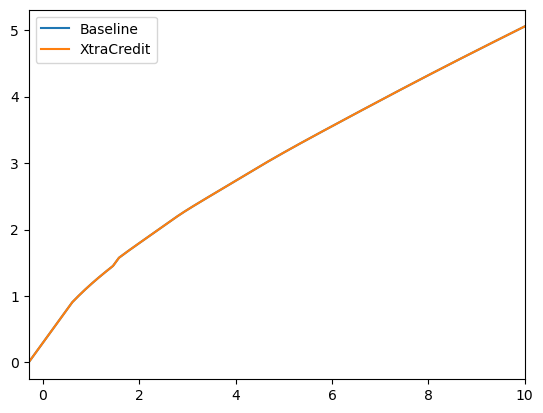

MPC out of Credit v MPC out of Income


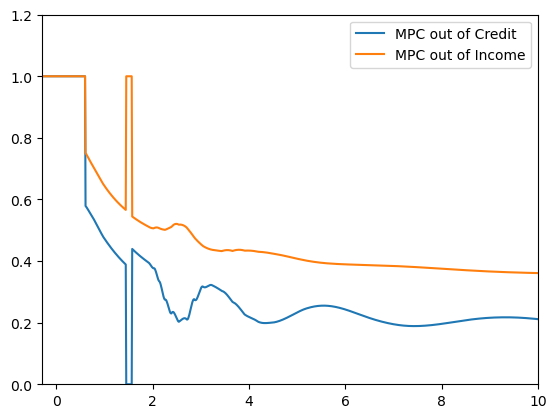

In [10]:
# Now, plot the functions we want
%matplotlib inline
# Import a useful plotting function from HARK.utilities


# Declare the upper limit for the graph
x_max = 10.0


# Note that plot_funcs takes four arguments: (1) a list of the arguments to plot,
# (2) the lower bound for the plots, (3) the upper bound for the plots, and (4) keywords to pass
# to the legend for the plot.

# Plot the consumption functions to compare them
# The only difference is that the XtraCredit function has a credit limit that is looser
# by a tiny amount
print(
    "The XtraCredit consumption function allows the consumer to spend a tiny bit more"
)
print(
    "The difference is so small that the baseline is obscured by the XtraCredit solution"
)
plot_funcs(
    [BaselineExample.solution[0].cFunc, XtraCreditExample.solution[0].cFunc],
    BaselineExample.solution[0].mNrmMin,
    x_max,
    legend_kwds={"loc": "upper left", "labels": ["Baseline", "XtraCredit"]},
)


# Plot the MPCs to compare them
print("MPC out of Credit v MPC out of Income")
plt.ylim([0.0, 1.2])
plot_funcs(
    [FirstDiffMPC_Credit, FirstDiffMPC_Income],
    BaselineExample.solution[0].mNrmMin,
    x_max,
    legend_kwds={"labels": ["MPC out of Credit", "MPC out of Income"]},
)